In [1]:
# Import everything that we are going to need
import pandas as pd
import geopandas
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import scipy.interpolate

In [3]:
#Date 15/07/2007
#Terra MODIS
Terradata1030Z=xr.open_dataset('/neodc/eustace/data/satellite_skin_temperature/UOL/land/MODIS_Terra/L2/GT_MOG_2P/v2.1/2007/07/15/GT_SSD-L2-MOGSV_LST_2-20070715_103000-CUOL-0.01X0.01-V2.1.nc')
Terradata2140Z=xr.open_dataset('/neodc/eustace/data/satellite_skin_temperature/UOL/land/MODIS_Terra/L2/GT_MOG_2P/v2.1/2007/07/15/GT_SSD-L2-MOGSV_LST_2-20070715_214000-CUOL-0.01X0.01-V2.1.nc')

#Aqua MODIS
Aquadata0105Z=xr.open_dataset('/neodc/eustace/data/satellite_skin_temperature/UOL/land/MODIS_Aqua/L2/GT_MYG_2P/v2.1/2007/07/15/GT_SSD-L2-MYGSV_LST_2-20070715_010500-CUOL-0.01X0.01-V2.1.nc')
Aquadata1215Z=xr.open_dataset('/neodc/eustace/data/satellite_skin_temperature/UOL/land/MODIS_Aqua/L2/GT_MYG_2P/v2.1/2007/07/15/GT_SSD-L2-MYGSV_LST_2-20070715_121500-CUOL-0.01X0.01-V2.1.nc')


In [4]:
#Change from array to dataframe
df_Terradata1030Z = Terradata1030Z.to_dataframe()
df_Terradata2140Z = Terradata2140Z.to_dataframe()
df_Aquadata0105Z = Aquadata0105Z.to_dataframe()
df_Aquadata1215Z = Aquadata1215Z.to_dataframe()

In [5]:
#select a subset (Area containing Milan city centre and 39km around it, taken from Anniballe 2014)
#45.29<lat<45.64, 8.91<lon<9.42
subset_Terradata1030Z= df_Terradata1030Z[(df_Terradata1030Z.lat >45.29) & (df_Terradata1030Z.lat < 45.65) & (df_Terradata1030Z.lon > 8.91) & (df_Terradata1030Z.lon < 9.42)]

In [63]:
subset_Terradata1030Z["LST"].mean()

314.22214

In [6]:
#Need to project the lat and lon coordinates onto a grid
#start by importing the packages we need to do this
import shapely.geometry
import pyproj
from shapely.geometry import Point, LineString, Polygon
from cartopy import crs as ccrs

In [7]:
#Change the coordinate reference system
#lat and lon coordinates are not accurate as they are distorted by the shape of the map
subset_Terradata1030Z_df_geometry = [Point(xy) for xy in zip(subset_Terradata1030Z.lon, subset_Terradata1030Z.lat)]

gdf = geopandas.GeoDataFrame(subset_Terradata1030Z, geometry=subset_Terradata1030Z_df_geometry)
gdf.crs= {'init': 'epsg:4326', 'no_defs': True}

In [8]:
gdf2 = gdf.to_crs(epsg=3003) #epsg 3003 is mainland italy, units in m, cartesian 2D axis

In [ ]:
#df1= pd.DataFrame(gdf2)

In [9]:
#Extract the x and y coordinates 
x_points = gdf2['geometry'].x
y_points = gdf2['geometry'].y

In [10]:
#Add the extracted coordinates to dataframe
gdf2['xpoints'] = x_points
gdf2['ypoints'] = y_points

In [168]:
#gdf2

In [11]:
#Determine the origin
origin_x = min(gdf2.xpoints)
origin_y = min(gdf2.ypoints)

In [12]:
#Subtract the orgin from the points
gdf2['x_points'] = gdf2['xpoints'] - origin_x
gdf2['y_points'] = gdf2['ypoints'] - origin_y

In [13]:
#Drop the xpoints and ypoints columns as they are no longer needed
gdf2 = gdf2.drop('xpoints', axis = 1)
gdf2 = gdf2.drop('ypoints', axis = 1)

In [14]:
#Check points by plotting
#specify x,y,LSTs
x= gdf2.x_points
y= gdf2.y_points
LST = gdf2.LST

In [82]:
#Check points by plotting
#get the points into the correct format
X,Y = np.meshgrid(x,y)
Z = scipy.interpolate.griddata((x, y), LST, (X,Y), method='nearest')

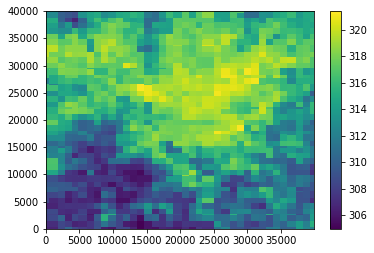

In [126]:
#Make plot
#Colour mesh plot
plt.pcolormesh(X,Y,Z)
plt.colorbar()

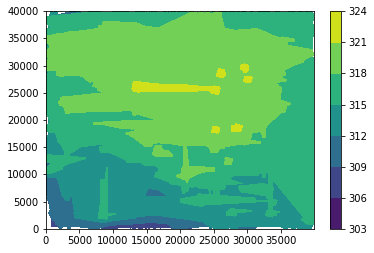

In [125]:
#Make plot
#Contour plot
plt.contourf(X,Y,Z,levels = 5)
plt.colorbar()

In [94]:
Z

array([[312.72998, 312.72998, 312.72998, ..., 314.91   , 314.91   ,
        314.91   ],
       [315.09   , 315.09   , 315.09   , ..., 314.58   , 315.07   ,
        315.07   ],
       [314.16   , 314.16   , 314.16   , ..., 314.58   , 314.58   ,
        314.58   ],
       ...,
       [308.59   , 308.59   , 308.3    , ..., 313.9    , 313.9    ,
        313.9    ],
       [307.08   , 307.08   , 307.08   , ..., 315.34   , 315.34   ,
        315.34   ],
       [306.62   , 306.62   , 306.62   , ..., 312.16998, 312.16998,
        312.16998]], dtype=float32)

In [15]:
#Take a look at QC flags
QC = gdf2.QC

In [16]:
#Apply the function to the QC list to check bytes 1 and 2. Then append this new list onto our data frame. 
#first off all define the functions

#function to check the status of a byte on the QC control
def check_bits(x,n):
    if (x & (1<<n)): 
  ## n-th bit is 1 
        flag = 1
    else:
  ## n-th bit is 0
        flag = 0
    return flag

#function to check bytes 1 and 2 and return 0 if they are both 0
def quality_control(x):
    if ((check_bits(x,1) == 0) and (check_bits(x,2) == 0)):
  ##if bit 1 and bit 2 are 0 then 0 
        flag = 0
    else:
  ##otherwise flag is 1
        flag = 1
    return flag


In [17]:
#Apply to function to QC
QC2 = np.array([quality_control(int(i)) for i in QC])

In [18]:
#Now need to add this QC2 flag onto the dataset
gdf2['QC_2'] = QC2

In [19]:
#Look at the points which are not useable based on the QC flag
#first grid the QC_2 flag
QC_2 = gdf2.QC_2
QC_Z = scipy.interpolate.griddata((x, y), QC_2, (X,Y), method='nearest')

NameError: name 'X' is not defined

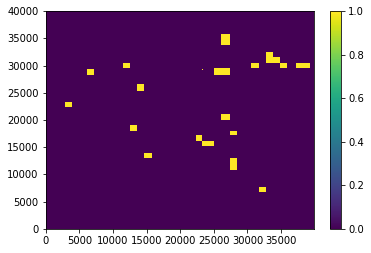

In [123]:
#Then plot 
plt.pcolormesh(X,Y,QC_Z)
plt.colorbar()

In [20]:
#Now need to apply a mask to the urban area and poor quality pixels
#so, mask out where QC_2 = 1 and using a land cover map
#first need to load up the land cover use data
#crs wgs84
#code for urban areas: 190
LULC_ds=xr.open_dataset('/neodc/esacci/land_cover/data/land_cover_maps/v2.0.7/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2007-v2.0.7b.nc')

In [21]:
#Take the subset of required area, this must be done to the data array as the dataset is very large and needs to be made smaller before it can be a dataframe
#select a subset (Area containing Milan city centre and 39km around it, taken from Anniballe 2014)
#45.29<lat<45.64, 8.91<lon<9.42
temp_subset_LULC_ds = LULC_ds.sel(lat =(LULC_ds.lat >45.29) & (LULC_ds.lat < 45.65))
subset_LULC_ds = temp_subset_LULC_ds.sel(lon =(temp_subset_LULC_ds.lon >8.91) & (temp_subset_LULC_ds.lon < 9.42))

In [6]:
#Checking the dataset
subset_LULC_ds

<xarray.Dataset>
Dimensions:              (lat: 130, lon: 183)
Coordinates:
  * lat                  (lat) float32 45.648613 45.645832 ... 45.29028
  * lon                  (lon) float32 8.9125 8.9152775 ... 9.4152775 9.418056
Data variables:
    lccs_class           (lat, lon) float32 ...
    processed_flag       (lat, lon) float32 ...
    current_pixel_state  (lat, lon) float32 ...
    observation_count    (lat, lon) float32 ...
    change_count         (lat, lon) float32 ...
    crs                  int32 ...
Attributes:
    title:                      ESA CCI Land Cover Map
    summary:                    This dataset contains the global ESA CCI land...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2007-v2.0.7
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    institution:                Universite cathol

In [7]:
lccs_class = subset_LULC_ds.lccs_class

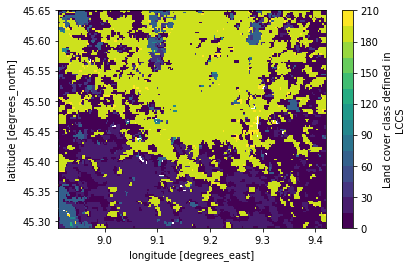

In [8]:
lccs_class.plot(levels = 20)

In [22]:
#Add lat and lon as variables so more easy to use in dataframe
subset_LULC_ds['lats'] = subset_LULC_ds['lat']
subset_LULC_ds['lons'] = subset_LULC_ds['lon']

In [23]:
#send to dataframe
subset_LULC_df = subset_LULC_ds.to_dataframe()

In [24]:
#Add in is_urban flag, where the lccs_class is 190
subset_LULC_df['is_urban'] = [1 if x == 190 else 0 for x in subset_LULC_df['lccs_class']]

In [25]:
#Convert coordinate system to get into the same x, y format as LSTs
#Change the coordinate reference system
#lat and lon coordinates are not accurate as they are distorted by the shape of the map
subset_LULC_df_geometry = [Point(xy) for xy in zip(subset_LULC_df.lons, subset_LULC_df.lats)]

subset_LULC_gdf = geopandas.GeoDataFrame(subset_LULC_df, geometry=subset_LULC_df_geometry)
subset_LULC_gdf.crs= {'init': 'epsg:4326', 'no_defs': True} #current coordinate system is WGS84, EPSG:4326

subset_LULC_df_gdf2 = subset_LULC_gdf.to_crs(epsg=3003) #epsg 3003 is mainland italy, units in m, cartesian 2D axis

In [26]:
#Extract the x and y coordinates 
lu_x_points = subset_LULC_df_gdf2['geometry'].x
lu_y_points = subset_LULC_df_gdf2['geometry'].y

In [27]:
#Add the extracted coordinates to dataframe
subset_LULC_df_gdf2['xpoints'] = lu_x_points
subset_LULC_df_gdf2['ypoints'] = lu_y_points

In [28]:
#Need this new coordinate grid to be the same as the LST grid, so use the min x,y values from this to set the origin
#Subtract the orgin from the points
subset_LULC_df_gdf2['x_points'] = subset_LULC_df_gdf2['xpoints'] - origin_x
subset_LULC_df_gdf2['y_points'] = subset_LULC_df_gdf2['ypoints'] - origin_y

In [29]:
#Drop the xpoints and ypoints columns as they are no longer needed
subset_LULC_df_gdf2 = subset_LULC_df_gdf2.drop('xpoints', axis = 1)
subset_LULC_df_gdf2 = subset_LULC_df_gdf2.drop('ypoints', axis = 1)

In [30]:
#Combining to two dataframes
#Create empty columns to be filled in the main dataframe
gdf2['Distance'] = 'null'
gdf2['is_urban'] = 'null'

In [31]:
#Approach: Add the urban flag onto the main dataframe by finding the point in the LST frame which is closest
#NOTE: CAUTION if messing with the LULC dataframe as this may also effect this one (maybe use .copy later if this could be an issue)

#functions
#first of all calculate the distance between the two points
#then apply this element by element to the main dataframe, against all the points in the LULC dataframe to find the one which is the closest
#save the is_urban flag and the distance (as a sense check) in the main dataframe

def dist(dataframe,pt_x,pt_y):
    dataframe['Distance'] = np.sqrt(((dataframe['x_points']-pt_x) **2)+(dataframe['y_points']-pt_y)**2)

for i in range(len(gdf2)):
    dist(subset_LULC_df_gdf2,gdf2['x_points'].iloc[i],gdf2['y_points'].iloc[i])
    gdf2['is_urban'].iloc[i] = subset_LULC_df_gdf2['is_urban'][subset_LULC_df_gdf2['Distance'].idxmin(axis=1)]
    gdf2['Distance'].iloc[i] = subset_LULC_df_gdf2['Distance'][subset_LULC_df_gdf2['Distance'].idxmin(axis=1)] #Add in the distance as a sense check 


/opt/jaspy/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [103]:
#The max distance of all the points is ~230m
#Based on the main dataset resolution of 1km this is acceptable 
gdf2['Distance'].max()

230.59278468148943

In [33]:
#Save this dataframe so don't have to keep running the code everytime 
#Save as a pickle
gdf2.to_pickle('gdf2')

In [2]:
#To load the dataframe back in
gdf2 = pd.read_pickle('gdf2')

In [37]:
#Now can look at the distribution of the urban area
####Come back to if the dataframe gets smaller (to big at present, 23790 rows × 9 columns)
#Look at urban land cover
#get the points into the correct format
x_lu = gdf2['lon']
y_lu = gdf2['lat']
U_lu = gdf2['is_urban']

X_lu,Y_lu = np.meshgrid(x_lu,y_lu)
Z_lu = scipy.interpolate.griddata((x_lu, y_lu), U_lu, (X_lu,Y_lu), method='nearest')

Text(0.5, 1.0, 'Urban Pixels (yellow)')

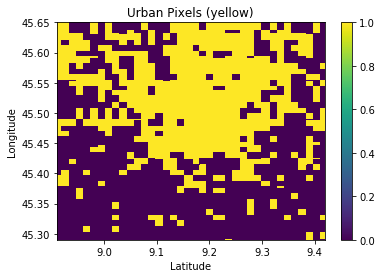

In [38]:
#Make plot
#Colour mesh plot
plt.pcolormesh(X_lu,Y_lu, Z_lu)
plt.colorbar()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Urban Pixels (yellow)')

In [3]:
#The first step is to mask out all the urban pixels and cloudy pixels
#So apply mask flag set to 1 if QC_2 = 1 OR is_urban = 1
#Should the pixels which appear to be in the middle be masked out too? 

#Create the function
def to_mask(row):
    if row['QC_2'] == 1:
        return 1
    elif row['is_urban'] == 1:
        return 1
    else:
        return 0

#Apply to create new column
gdf2['apply_mask'] = gdf2.apply(lambda row: to_mask(row), axis=1)

In [5]:
#Select a subset of the data, which the mask has not been applied to 
#will then apply a mulitple linear regression (with 2 variables, x and y) to this subset to get something of the form
# LST = T0 + (a1)x + (a2)y
#T0, a1, a2 coefficients to be determined

#first create a copy of the main dataframe to use
rural_df = gdf2.copy()

#select the required rows of the unmasked variables (where apply_mask = 0)
rural_df = rural_df.loc[rural_df['apply_mask'] == 0]

#take out useful rows
rural_df1 = rural_df[['lat','lon','LST','x_points','y_points']].copy()

In [68]:
#Regression packages (used for polynomial regression too)
#import the required packages
import operator
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [ ]:
#Check if any of the data is null
rural_df1.isnull().any()

Text(0, 0.5, 'LST')

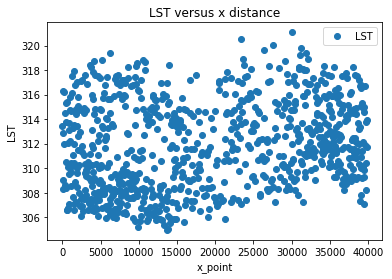

In [18]:
#First want to look at the distribution of the data to check it satisfies the criteria for a linear regression to be applied 
#Look at distribution for x distance
rural_df1.plot(x='x_points', y='LST', style = 'o')
plt.title('LST versus x distance')
plt.xlabel('x_point')
plt.ylabel('LST')

Text(0, 0.5, 'LST')

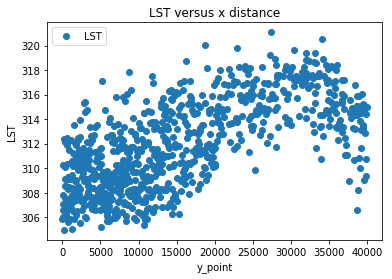

In [19]:
#Look at distribution for y distance
rural_df1.plot(x='y_points', y='LST', style = 'o')
plt.title('LST versus x distance')
plt.xlabel('y_point')
plt.ylabel('LST')

In [7]:
#seaborn isn't in the jasmin environment, so save dataframe as a pickle, download and do seaborn analysis separately
rural_df1.to_pickle('rural_df1')

#rural_df1 = pd.read_pickle('rural_df1')

#plot the distribution using seaborn in order to see if LST is normally distributed

In [6]:
#perform a ks test to see if the distribution of LST is normal
from scipy.stats import norm, kstest
#x is a list of the LSTs
x= rural_df1['LST'].tolist()

#generate what the normal distribution parameters of this would be 
loc, scale = norm.fit(x)
n=norm(loc=loc, scale=scale)

stats.kstest(x, n.cdf)

#Result: KstestResult(statistic=0.063, pvalue=0.0023)

KstestResult(statistic=0.06296680680843586, pvalue=0.0023494556908092434)

In [7]:
#perform a shapiro wilks test
stats.shapiro(x)

#Result: 0.97, 9.88e-12

(0.9717303514480591, 9.883936551158268e-12)

In [8]:
#Now to perform the regression
#Divide the data into attributes and labels
X= rural_df1[['x_points','y_points']].values

y = rural_df1['LST'].values

#Split the data, 80% to training set, 20% to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 0)

In [20]:
#Fit the model to the training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [35]:
#Look at the coefficients and intercept
X = pd.DataFrame(X) #had to convert from np array to panda dataframe to use .columns
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
0,0.000069
1,0.000211


In [36]:
#View intercept
print(regressor.intercept_)

307.22703771780965


In [39]:
#Use the regression model to make a prediction using the test data
y_pred = regressor.predict(X_test)

pred_df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})

pred_df1 = pred_df.head(25)

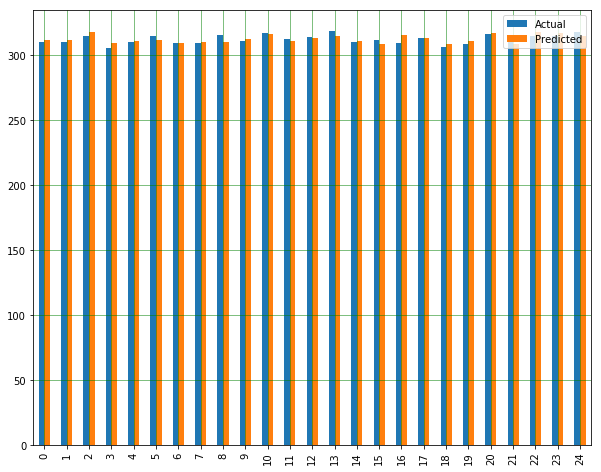

In [42]:
#Comparison plot of actual and predicted values
pred_df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [43]:
#Evaluate performance of the regression
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 2.080073458335816
Mean Squared Error: 6.287598823255018
Root Mean Squared Error: 2.507508489169083


In [9]:
#Mean temperature, potential T0
T_0 = y.mean()

In [10]:
#For the moment, use T0 = 311.8 as the background rural temperature
#Now to start to model the SUHI
#Need to take only the urban pixels which are good quality (where is_urban = 1 and QC_2 = 0)

urban_df = gdf2.copy()

urban_df = urban_df.loc[urban_df['is_urban'] == 1]
urban_df = urban_df.loc[urban_df['QC_2'] == 0]

In [11]:
#add in column for the SUHI = LST - T0 
#T0
urban_df['SUHI'] = urban_df['LST'] - T_0 
#In order to take the log, the SUHI values <=0 must be removed as it is not possible to take the log of these
#goes from 622 entries to 608 (14 pixels removed)

urban_df = urban_df.loc[urban_df['SUHI'] > 0]

In [12]:
#add in the column containing the logs
urban_df['ln_SUHI'] = np.log(urban_df['SUHI'].values)


In [66]:
#Take a look at the SUHI
#make the grids
x_suhi = urban_df['lon']
y_suhi = urban_df['lat']
U_suhi = urban_df['SUHI']

X_suhi,Y_suhi = np.meshgrid(x_suhi,y_suhi)
Z_suhi = scipy.interpolate.griddata((x_suhi, y_suhi), U_suhi, (X_suhi,Y_suhi), method='nearest')

Text(0.5, 1.0, 'SUHI')

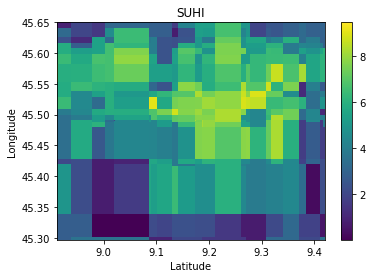

In [67]:
#Make plot
#Colour mesh plot
plt.pcolormesh(X_suhi,Y_suhi, Z_suhi)
plt.colorbar()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('SUHI')

In [29]:
#take out useful rows
urban_df1 = urban_df[['lat','lon','ln_SUHI','SUHI','x_points','y_points']].copy()

In [48]:
x_points = urban_df1['x_points']
y_points = urban_df1['y_points']
SUHI = urban_df1['SUHI']
ln_SUHI = urban_df1['ln_SUHI']

[Text(0, 0.5, 'ln(SUHI)'), Text(0.5, 0, 'y distance')]

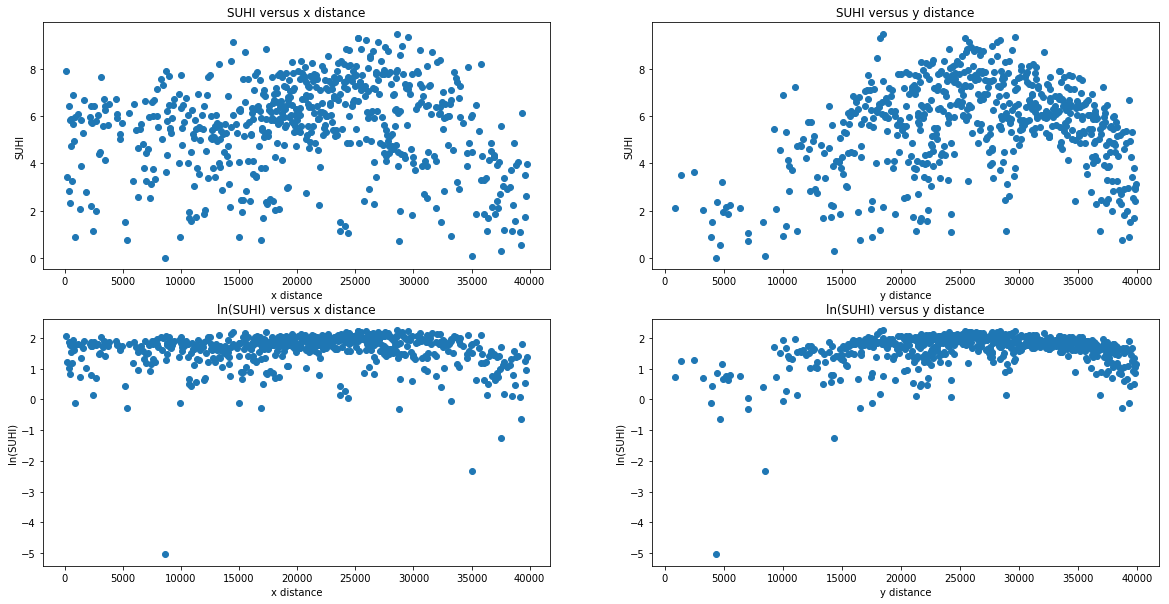

In [67]:
#Scatterplots
#Look at distribution for x distance

fig, axes = plt.subplots(nrows = 2,ncols = 2, figsize=(20, 10))

axes[0,0].scatter(x_points, SUHI)
axes[0,0].set_title('SUHI versus x distance')
axes[0,0].set(xlabel = 'x distance', ylabel = 'SUHI')

axes[0,1].scatter(y_points, SUHI)
axes[0,1].set_title('SUHI versus y distance')
axes[0,1].set(xlabel = 'y distance', ylabel = 'SUHI')

axes[1,0].scatter(x_points, ln_SUHI)
axes[1,0].set_title('ln(SUHI) versus x distance')
axes[1,0].set(xlabel = 'x distance', ylabel = 'ln(SUHI)')

axes[1,1].scatter(y_points, ln_SUHI)
axes[1,1].set_title('ln(SUHI) versus y distance')
axes[1,1].set(xlabel = 'y distance', ylabel = 'ln(SUHI)')


In [81]:
#Polynomial regression
#equation is of form ln_SUHI = b1 (x^2) +b2 xy +b3 y^2 + b4 x + b5 y + b6

#set variables to use
#Divide the data into attributes and labels

X = urban_df1[['x_points','y_points']].values
poly= PolynomialFeatures(degree=2) #
X_poly = poly.fit_transform(X)      #generate the polynomial and interaction feature in form [1, a, b, a^2, ab, b^2]
                                    #so column 0:1 c1:x c2:y c3:x^2 c4: xy c5:y^2

y = urban_df1['ln_SUHI'].values

#Split the data, 80% to training set, 20% to test set
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size= 0.2, random_state = 0) # note: Shuffle = True by default


In [82]:
#Fit the model to the training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [83]:
#Look at the coefficients and intercept
Xpoly = pd.DataFrame(X_poly) #had to convert from np array to panda dataframe to use .columns
coeff_df = pd.DataFrame(regressor.coef_, Xpoly.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
0,0.000000e+00
1,9.675635e-05
2,1.958223e-04
3,-1.631447e-09
4,-9.873155e-10
5,-3.214229e-09


In [84]:
#View intercept
print(regressor.intercept_)

-1.7075229073199385


In [91]:
#Use the regression model to make a prediction using the test data
y_pred = regressor.predict(X_test)

pred_df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})

pred_df_SUHI = np.exp(pred_df)

pred_df1 = pred_df.head(25)
pred_df1_SUHI = pred_df_SUHI.head(25)

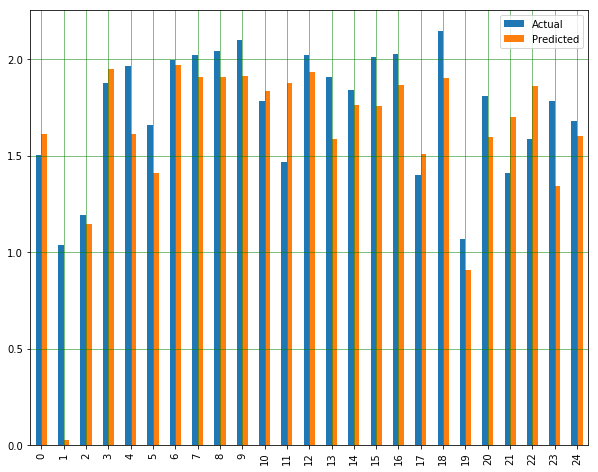

In [87]:
#Comparison plot of actual and predicted values for ln(SUHI)
pred_df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

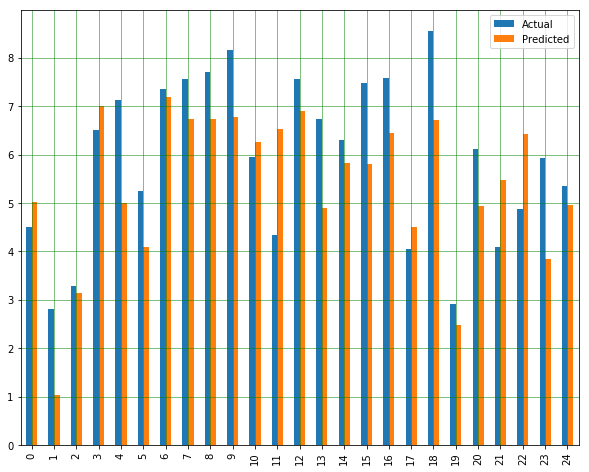

In [92]:
#Comparison plot of actual and predicted values for SUHI
pred_df1_SUHI.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [88]:
#Evaluate performance of the regression
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.28933319292664134
Mean Squared Error: 0.2357779586326652
Root Mean Squared Error: 0.48556972581974794
